# Time-series Analysis and Stock Price Forecast Modeling 

# /home/jovyan/data/stock_market_data/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

import datetime

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# LOAD DATA FOR American Airlines Group Inc. Common Stock (AAL)

In [8]:
url = "/home/jovyan/data/stock_market_data//nasdaq/csv/AAL.csv"
_df =pd.read_csv(url,sep=',')
len(_df)

4333

In [6]:
# copy data
df= _df.copy()

df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


# Data Wrangling and Preprocessing 

In [9]:
# check start-date of data
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


In [10]:
# check end-date of data
df.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close
4328,06-12-2022,14.00,14.14,20781500,14.34,14.330,14.330
4329,07-12-2022,13.53,14.24,28161400,14.24,13.550,13.550
4330,08-12-2022,13.38,13.65,25300900,13.80,13.600,13.600
4331,09-12-2022,13.42,13.52,18489800,13.66,13.530,13.530
4332,12-12-2022,13.45,13.49,8048550,13.93,13.915,13.915


In [11]:
df.shape


(4333, 7)

In [ ]:
# This shows that we have 4333 rows and 7 columns.

# Check Missing Data

In [12]:
df.isna().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [13]:
df.dtypes

Date               object
Low               float64
Open              float64
Volume              int64
High              float64
Close             float64
Adjusted Close    float64
dtype: object

In [14]:
# Convert 'Date' column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
df.dtypes

Date              datetime64[ns]
Low                      float64
Open                     float64
Volume                     int64
High                     float64
Close                    float64
Adjusted Close           float64
dtype: object

In [16]:
# Group the data by month and count the number of unique days per month
days_per_month = df.groupby(df['Date'].dt.to_period('M'))['Date'].nunique()

#convert series to dataframe
days_per_month = pd.DataFrame(days_per_month)
days_per_month.head(20)

,Date
Date,
2005-09,4
2005-10,21
2005-11,21
2005-12,21
2006-01,20
2006-02,19
2006-03,23
2006-04,19
2006-05,22


In [17]:
# Drop rows where the year is 2005
df = df[df['Date'].dt.year != 2005]

#  resetting the DataFrame index
df.reset_index(inplace = True, drop = True)

df.head(5)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242


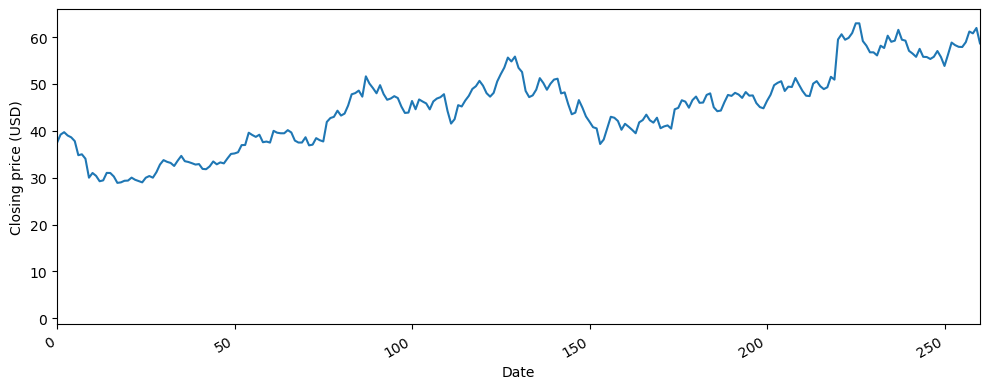

In [18]:
# Plot first year (260 day) of target

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

ax.set_xlim(0, 260)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
df.to_csv('../clean_AAL.csv', header=True, index=False)


# Feature Engineering

In [19]:
df.describe().T


,count,mean,min,25%,50%,75%,max,std
Date,4266,2014-06-23 15:07:40.759493632,2006-01-03 00:00:00,2010-03-30 06:00:00,2014-06-24 12:00:00,2018-09-17 18:00:00,2022-12-12 00:00:00,NaN
Low,4266.0,24.887229,1.45,10.535,21.335,39.139999,62.0,15.807891
Open,4266.0,25.38824,1.81,10.8225,21.89,39.745,62.700001,16.006334
Volume,4266.0,14589389.744491,191300.0,4749500.0,7557550.0,13528325.0,428617100.0,22074557.816849
High,4266.0,25.854116,2.03,11.1125,22.240001,40.2975,63.27,16.193664
Close,4266.0,25.356729,1.76,10.7925,21.815,39.704999,62.950001,16.004301
Adjusted Close,4266.0,24.399546,1.659225,10.241128,21.435,37.975982,59.345573,15.334426


In [20]:
# Identifying the seasonal period

df['Date'] = pd.to_datetime(df['Date'])

# Extract the month and year from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year


# Calculate the mean close price per month
monthly_mean = df.groupby([ 'Month'])['Close'].mean().reset_index()

# Calculate the mean close price per year
yearly_mean = df.groupby([ 'Year'])['Close'].mean().reset_index()

In [21]:
monthly_mean

,Month,Close
0,1,27.501545
1,2,27.312301
2,3,26.263324
3,4,25.501880
4,5,25.268106
5,6,24.701071
6,7,24.789972
7,8,23.683342
8,9,23.654870
9,10,24.397701


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


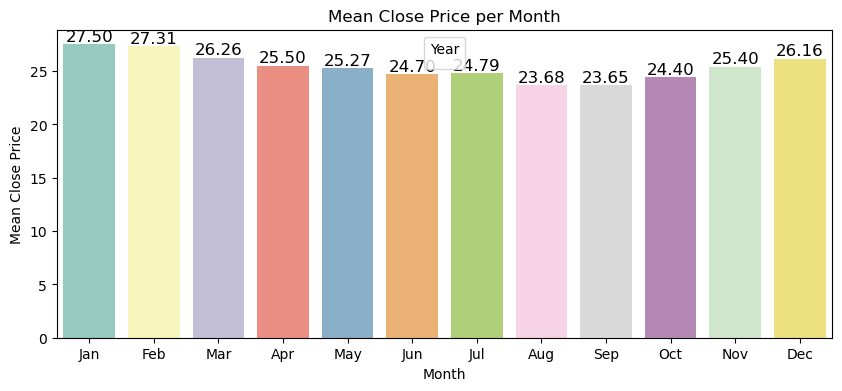

In [22]:
# Plot the mean close price per month using a Seaborn bar chart
ax =sns.barplot(data=monthly_mean, x='Month', y='Close',  palette='Set3')

plt.title('Mean Close Price per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')


for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')
plt.show()

In [23]:
yearly_mean.head()


,Year,Close
0,2006,44.322390
1,2007,35.671952
2,2008,7.742134
3,2009,3.829643
4,2010,8.636667


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


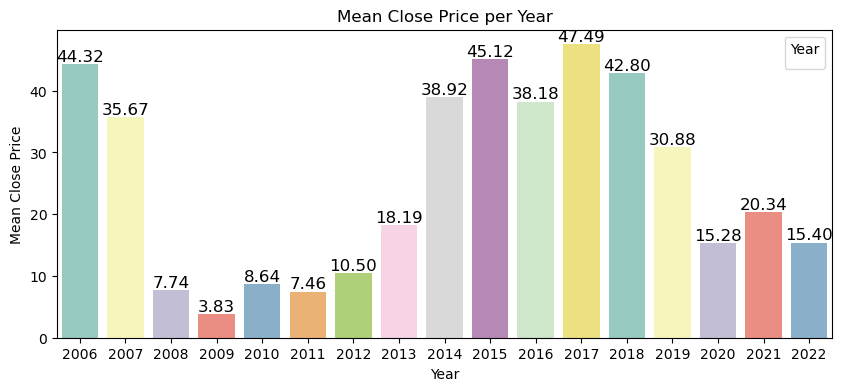

In [24]:
lst_year= yearly_mean['Year'].tolist()

# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=yearly_mean, x='Year', y='Close',  palette='Set3')

plt.title('Mean Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, len(lst_year)), labels=lst_year)
plt.legend(title='Year')

for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')

plt.show()

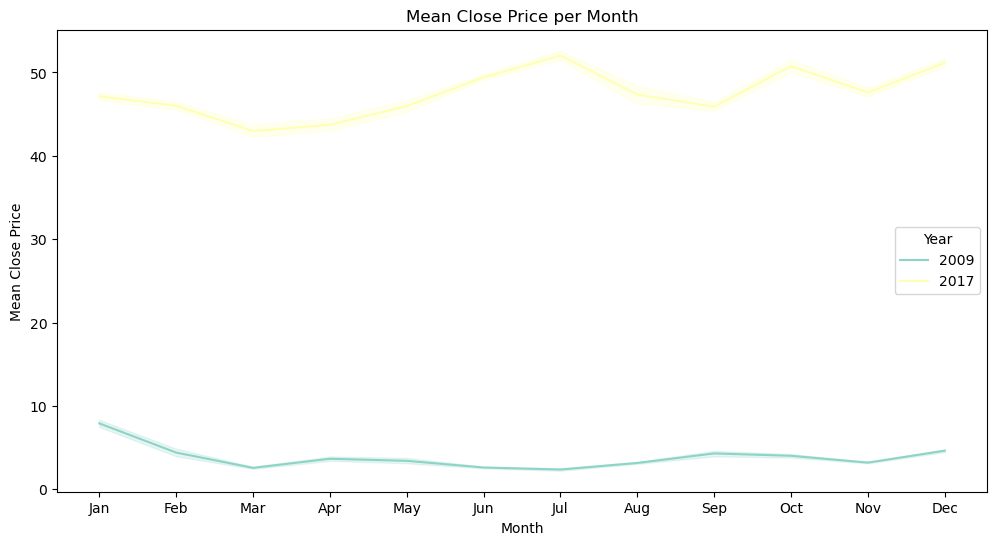

In [25]:
# Plot the mean close price per month using a Seaborn bar chart
plt.figure(figsize=(12, 6))

filtered_df = df[df['Year'].isin([2009,2017])]
sns.lineplot(data=filtered_df, x='Month', y='Close', hue='Year', palette='Set3')

plt.title('Mean Close Price per Month')

plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')
plt.show()

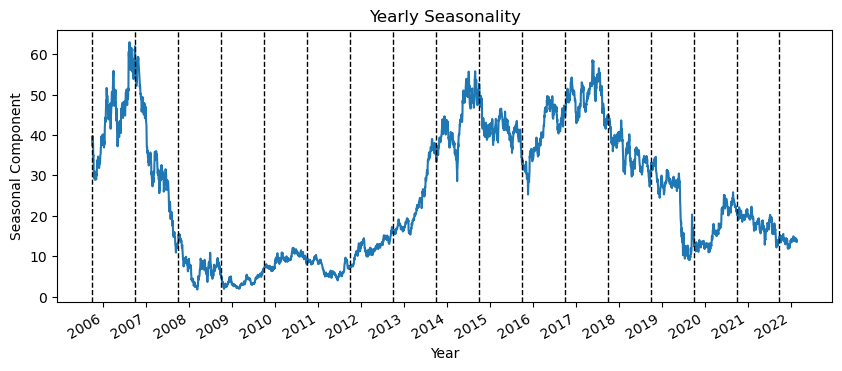

<Figure size 1000x500 with 0 Axes>

In [26]:
fig, ax = plt.subplots()

ax.plot(df['Close'])
for i in np.arange(0, len(df), 260):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Yearly Seasonality')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')

plt.xticks(np.arange(67, len(df), 260), np.arange(2006, 2023, 1))

plt.figure(figsize=(10, 5))

fig.autofmt_xdate()
plt.tight_layout()

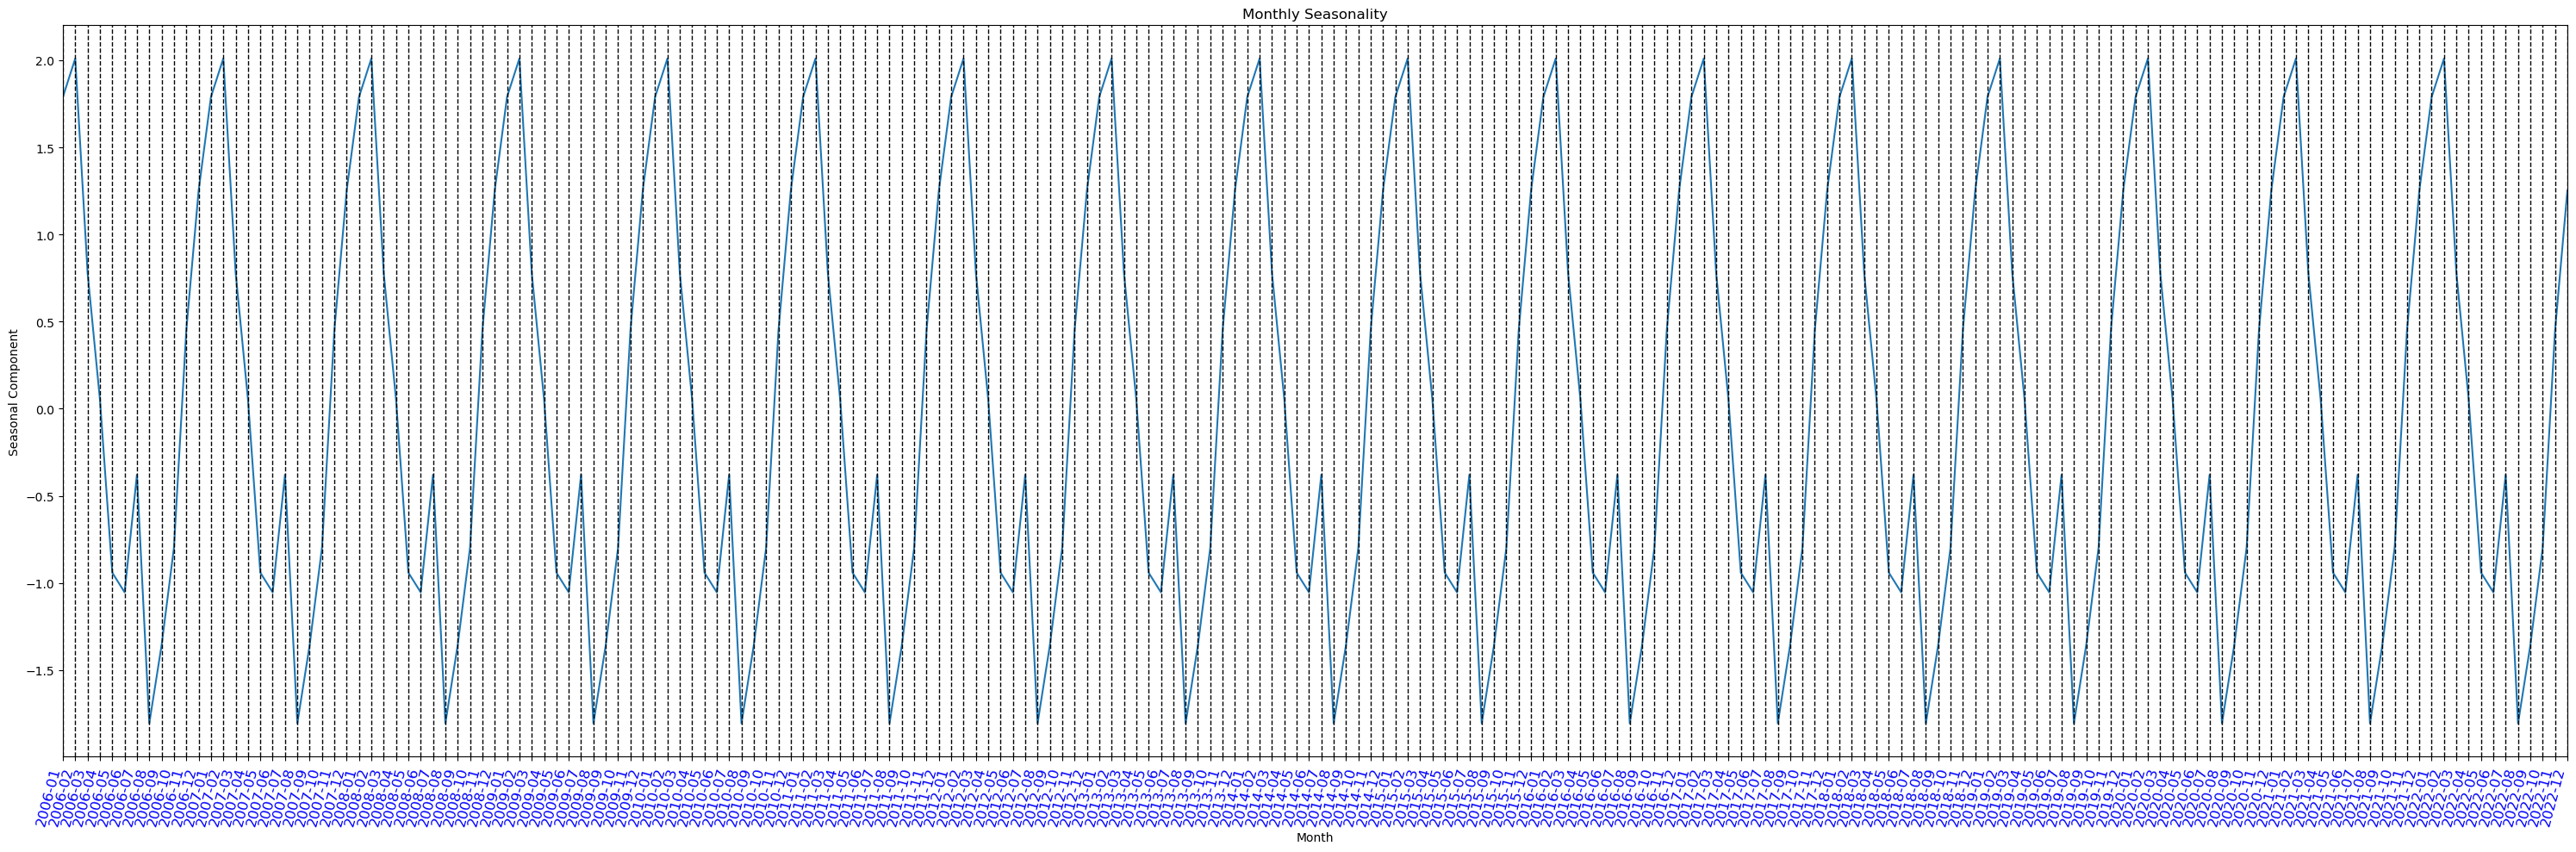

In [31]:
import statsmodels.api as sm

df_seasonality = df.copy()

# Set 'Date' column as the index of the DataFrame
df_seasonality.set_index('Date', inplace=True)

# Resample the data to monthly frequency
monthly_data = df_seasonality['Close'].resample('M').mean()

# Get the month numbers for the xticks
month_numbers = pd.to_datetime(monthly_data.index).strftime('%m')

# Define explicit frequency to avoid freq error
monthly_data = monthly_data.asfreq('M')

df_monthly_data= monthly_data.to_frame(name="Close")
df_monthly_data['month_numbers'] = month_numbers

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(monthly_data, model='additive', period=12)

# Plot the seasonal component
fig, ax = plt.subplots(figsize=(30, 10))

decomposition.seasonal.plot(ax=ax)

times = np.arange('2006-01', '2023-01', dtype='datetime64[M]')
ax.set_xticks(times)
# ax.set_xticklabels(times )

for i in np.arange(0, len(df), 1):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Monthly Seasonality' ,  fontsize = 12)
plt.xlabel('Month',  fontsize = 10)
plt.ylabel('Seasonal Component',fontsize = 10)

plt.rcParams['figure.figsize'] = (30, 10)

fig.autofmt_xdate()
ax.set_xticklabels(times,rotation = 75,
                   ha = 'right', fontsize = 12,
                   color = 'blue')

plt.tight_layout()
plt.show()

In [36]:
df.head()



,Date,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,1,2006
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,1,2006
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268,1,2006
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914,1,2006
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242,1,2006


In [37]:
# 'Month','Year',
cols_to_drop = ['Date']
df = df.drop(cols_to_drop, axis=1)

df.head()

,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,1,2006
1,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,1,2006
2,38.910000,39.180000,317900,39.709999,39.709999,37.436268,1,2006
3,38.139999,39.709999,349200,39.709999,39.000000,36.766914,1,2006
4,38.500000,38.799999,220800,38.880001,38.610001,36.399242,1,2006


# Splitting and scaling the data

In [39]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [41]:
train_df.to_csv('../train.csv', index=False, header=True)
val_df.to_csv('../val.csv', index=False, header=True)
test_df.to_csv('../test.csv', index=False, header=True)

# Preparing for modeling with deep learning

In [42]:
train_df = pd.read_csv('../train.csv')
val_df = pd.read_csv('../val.csv')
test_df = pd.read_csv('../test.csv')


In [43]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Defining the DataWindow class

In [44]:
class DataWindow():

  def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df

            #Name of the column that we wish to predict
            self.label_columns = label_columns
            if label_columns is not None:
                #Create a dictionary with the name and index of the label column. This will be used for plotting.
                self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            #Create a dictionary with the name and index of each column. This will be used to separate the features from the target variable
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            #The slice function returns a slice object that specifies how to slice a sequence.
            # In this case, it says that the input slice starts at 0 and ends when we reach the input_width.
            self.input_slice = slice(0, input_width)
            #Assign indices to the inputs. These are useful for plotting.
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]


            #Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
            self.label_start = self.total_window_size - self.label_width
            #The same steps that were applied for the inputs are applied for labels.
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_to_inputs_labels(self, features):
            #Slice the window to get the inputs using the input_slice defined in __init__.
            inputs = features[:, self.input_slice, :]
            #Slice the window to get the labels using the labels_slice defined in __init__
            labels = features[:, self.labels_slice, :]

            #If we have more than one target, we stack the labels.
            if self.label_columns is not None:
                labels = tf.stack(
                    [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                    axis=-1
                )
            #The shape will be [batch, time, features].
            # At this point,we only specify the time dimension and allow the batch and feature dimensions to be defined later.
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])

            return inputs, labels

  def plot(self, model=None, plot_col='Close', max_subplots=3):
            inputs, labels = self.sample_batch

            plt.figure(figsize=(12, 8))
            plot_col_index = self.column_indices[plot_col]
            max_n = min(max_subplots, len(inputs))

            #Plot the inputs. They will  appear as a continuous blue line with dots.
            for n in range(max_n):
                plt.subplot(3, 1, n+1)
                plt.ylabel(f'{plot_col} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                  label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                  label_col_index = plot_col_index

                if label_col_index is None:
                  continue

                #Plot the labels or actual. They will appear as green squares.
                plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', marker='s', label='Labels', c='green', s=64)
                if model is not None:
                  predictions = model(inputs)
                  #Plot the predictions. They will appear as red crosses.
                  plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='red', s=64)

                if n == 0:
                  plt.legend()

            plt.xlabel('Date (Day)')
            plt.ylabel('Closing price (USD)')

  def make_dataset(self, data):
            data = np.array(data, dtype=np.float32)
            ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                #Pass in the data. This corresponds to our training set, validation set, or test set.
                data=data,
                #Targets are set to None, as they are handled by the split_to_input_labels function.
                targets=None,
                #Define the total length of s the array, which is equal to the total window length.
                sequence_length=self.total_window_size,
                #Define the number of timesteps separating each sequence. In our case, we want the sequences to be consecutive, so sequence_stride=1.
                sequence_stride=1,
                #Shuffle the sequences. Keep in mind that the data is still in chronological order. We are simply shuffling the order of the sequences, which makes the model more robus
                shuffle=True,
                #Define the number of sequences in a single batch
                batch_size=32
            )

            ds = ds.map(self.split_to_inputs_labels)
            return ds

  @property
  def train(self):
      return self.make_dataset(self.train_df)

  @property
  def val(self):
      return self.make_dataset(self.val_df)

  @property
  def test(self):
      return self.make_dataset(self.test_df)

  @property
  def sample_batch(self):
    #Get a sample batch of data for plotting purposes. If the sample batch does not exist, we’ll retrieve a sample batch and cache it
      result = getattr(self, '_sample_batch', None)
      if result is None:
          result = next(iter(self.train))
          self._sample_batch = result
      return result

# Utility function to train our models

In [45]:
#The function takes a model, and a window of data from the DataWindow class.
# The patience: is the number of epochs after which the model should stop training if the validation loss does not improve;
# max_epochs: sets a maximum number of epochs to train the model.
def compile_and_fit(model, window, patience=3, max_epochs=50):

    #Early stopping occurs if 3 consecutive epochs do not decrease the validation loss, as set by the patience parameter
    # The validation loss is tracked to determine if we should apply early stopping or not.
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    # The MSE is used as the loss function.
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) #the MAE as an evaluation metric to compare the performance of our models

    # The model is fit on the training set.
    history = model.fit(window.train,
                       epochs=max_epochs,   #The model can train for at most 50 epochs, as set by the max_epochs parameter.
                       validation_data=window.val,
                       callbacks=[early_stopping]) #early_stopping is passed as a callback. If the validation loss does not decrease after 3 consecutive epochs, the model stops training. This avoids overfitting.

    return history

### Modeling with Deep Learning

In [51]:
multi_window = DataWindow(input_width=21, label_width=21, shift=21,label_columns=['Close'])

# Repeat last value - Baseline

In [52]:


class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 21, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 21, 1])

In [53]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2048 - mean_absolute_error: 0.2937  


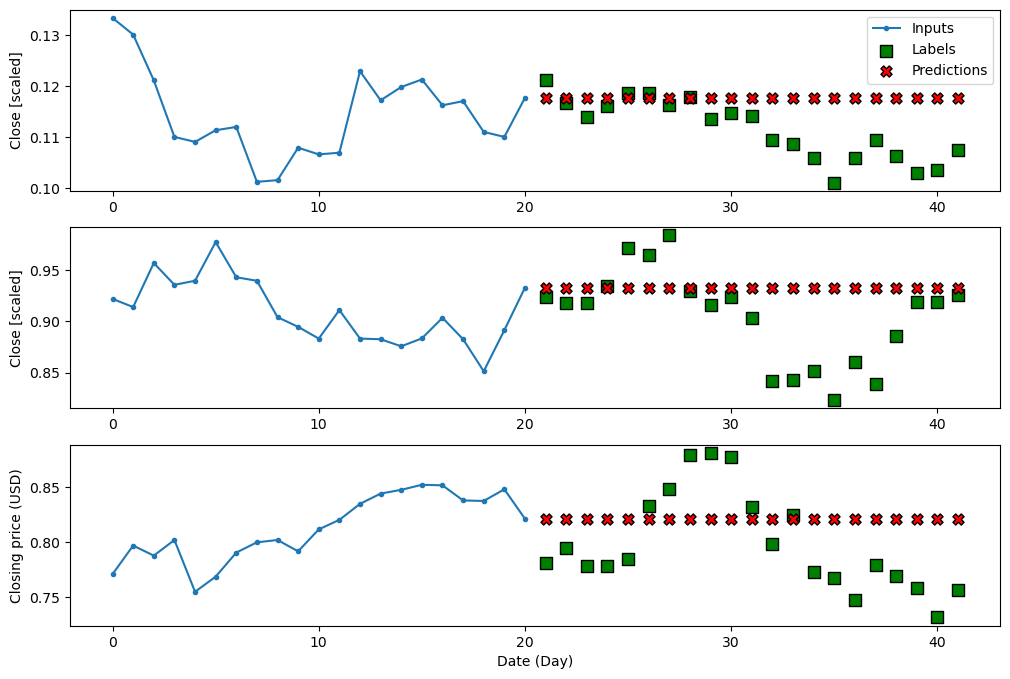

In [54]:
multi_window.plot(baseline_last)


# Repeat last day - Baseline

In [55]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [56]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2033 - mean_absolute_error: 0.3006  


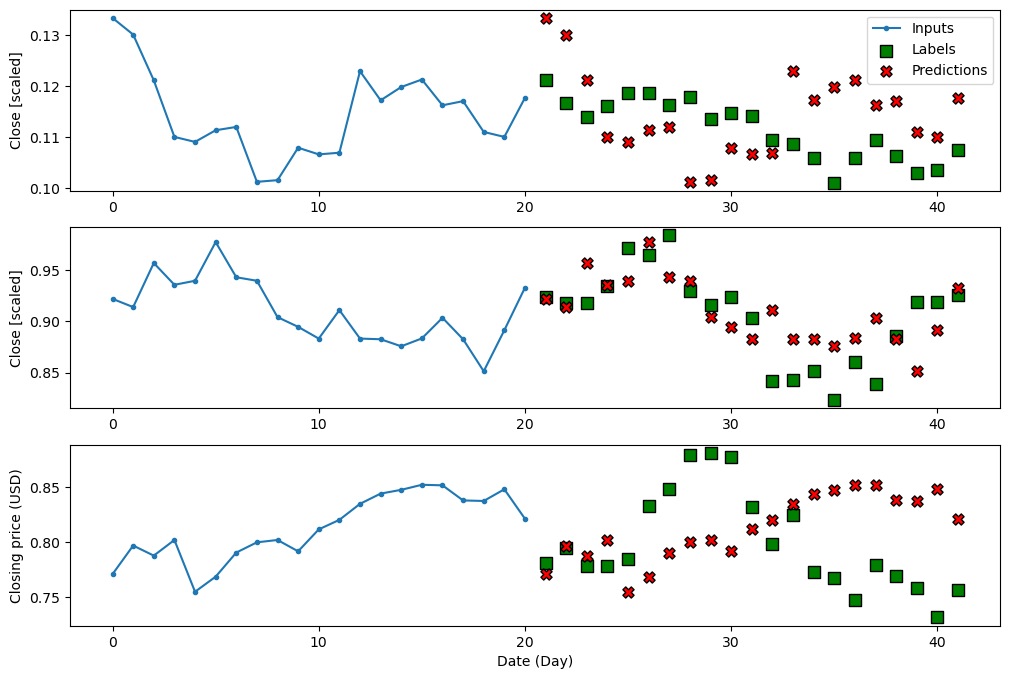

In [57]:
multi_window.plot(baseline_repeat)


# Linear model

In [58]:
label_index = column_indices['Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

In [59]:
history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1589 - mean_absolute_error: 0.3061 - val_loss: 0.0272 - val_mean_absolute_error: 0.1387
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - mean_absolute_error: 0.1441 - val_loss: 0.0204 - val_mean_absolute_error: 0.1140
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.1061 - val_loss: 0.0176 - val_mean_absolute_error: 0.1065
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0877 - val_loss: 0.0130 - val_mean_absolute_error: 0.0921
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0729 - val_loss: 0.0099 - val_mean_absolute_error: 0.0804
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - mean_absolute_error: 0.0617 - val_loss: 0.0082 - val_mean_absolute_error: 0.0721
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0536 - val_loss: 0.007

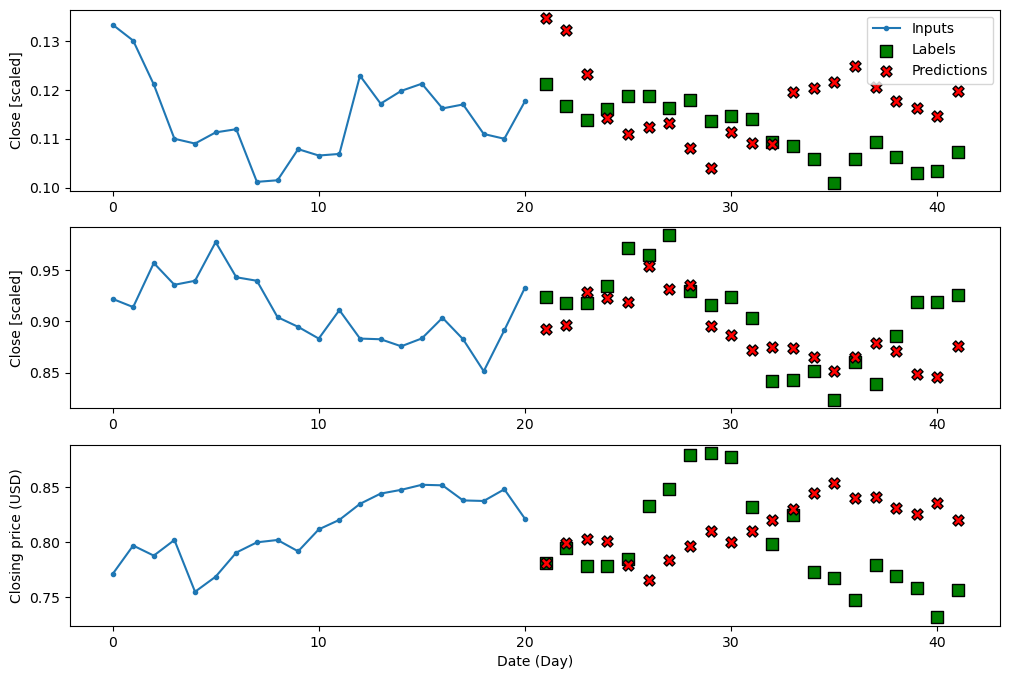

In [60]:
multi_window.plot(linear)


# Deep neural network - Dense Model

In [61]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1045 - mean_absolute_error: 0.2230 - val_loss: 0.0057 - val_mean_absolute_error: 0.0566
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0428 - val_loss: 0.0054 - val_mean_absolute_error: 0.0561
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0409 - val_loss: 0.0061 - val_mean_absolute_error: 0.0606
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0404 - val_loss: 0.0062 - val_mean_absolute_error: 0.0621
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0094 - val_mean_absolute_error: 0.0770
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0752


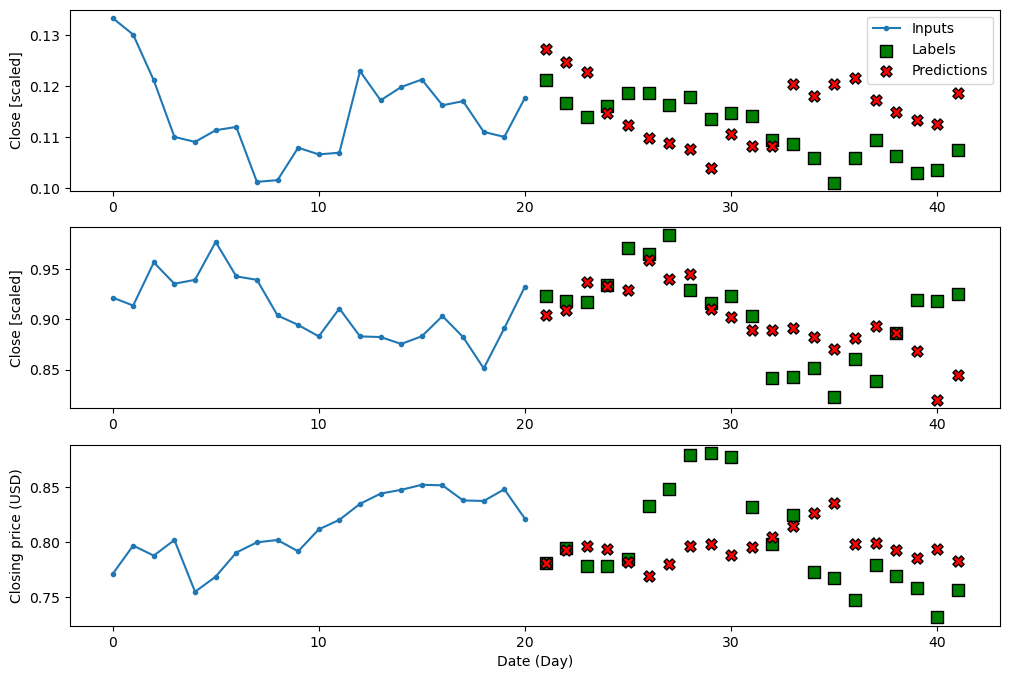

In [62]:
multi_window.plot(dense)

# Long short-term memory (LSTM) model 

In [63]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1231 - mean_absolute_error: 0.2507 - val_loss: 0.0157 - val_mean_absolute_error: 0.0895
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0653 - val_loss: 0.0121 - val_mean_absolute_error: 0.0829
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mean_absolute_error: 0.0554 - val_loss: 0.0110 - val_mean_absolute_error: 0.0817
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - mean_absolute_error: 0.0499 - val_loss: 0.0108 - val_mean_absolute_error: 0.0829
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0471 - val_loss: 0.0094 - val_mean_absolute_error: 0.0764
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_absolute_error: 0.0454 - val_loss: 0.0105 - val_mean_absolute_error: 0.0822
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0444 - val_loss: 0

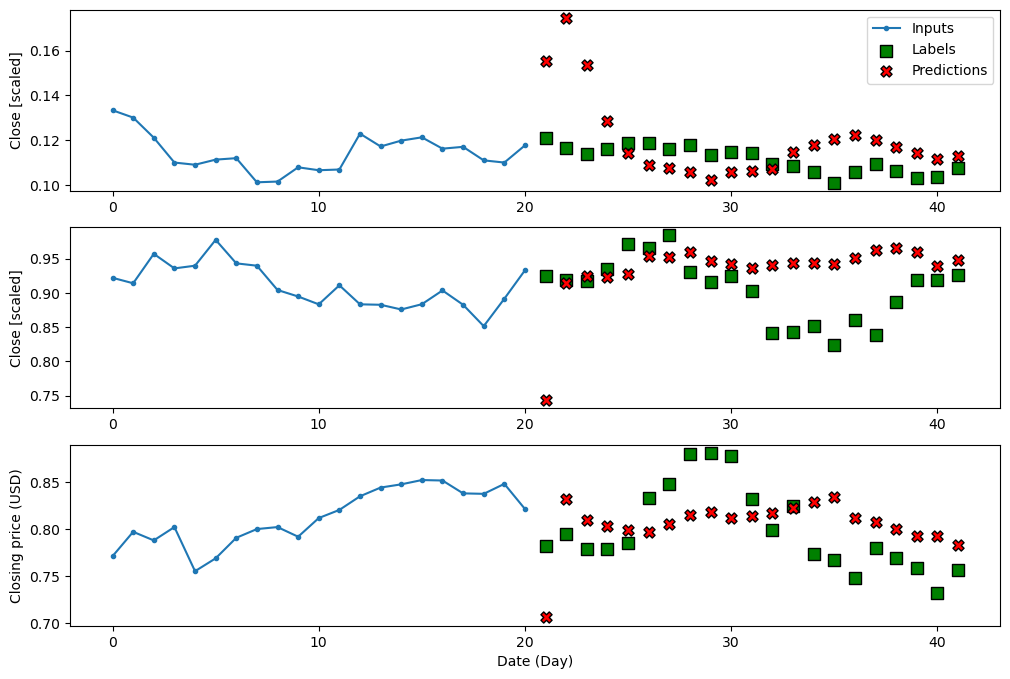

In [64]:
multi_window.plot(lstm_model)


# Convolutional neural network (CNN)

In [65]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 21
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [66]:
cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=21, label_columns=['Close'])

In [67]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1058 - mean_absolute_error: 0.2289 - val_loss: 0.0055 - val_mean_absolute_error: 0.0540
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - mean_absolute_error: 0.0446 - val_loss: 0.0053 - val_mean_absolute_error: 0.0537
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0427 - val_loss: 0.0049 - val_mean_absolute_error: 0.0533
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0416 - val_loss: 0.0057 - val_mean_absolute_error: 0.0586
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0055 - val_mean_absolute_error: 0.0592
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0082 - val_mean_absolute_error: 0.0720
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - mean_absolute_error: 0.0699


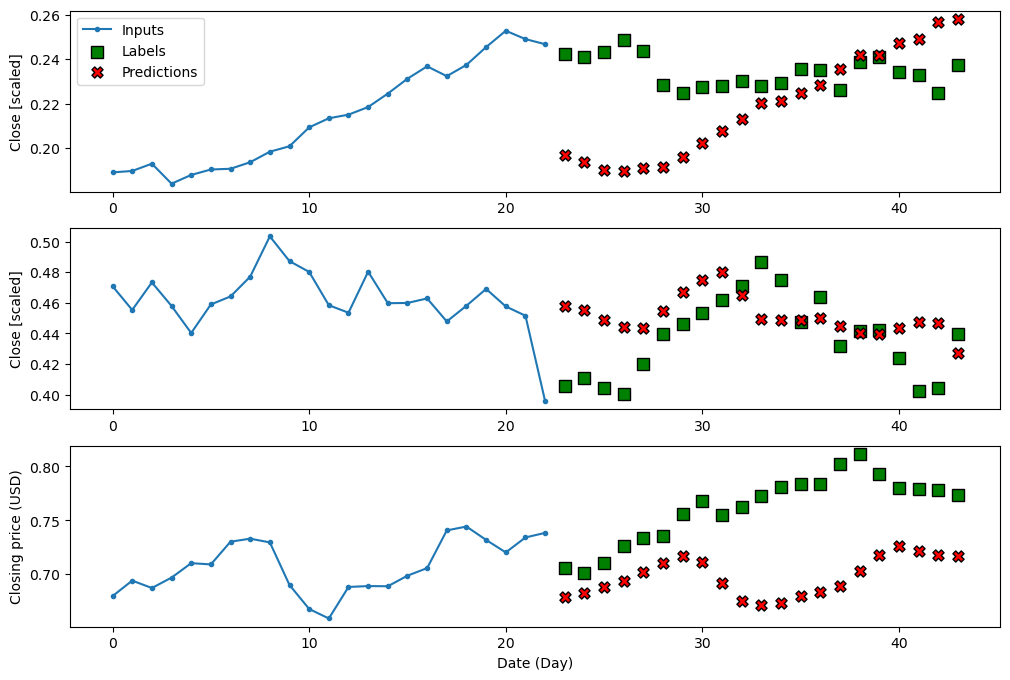

In [68]:
cnn_multi_window.plot(cnn_model)

 # Combining a CNN with an LSTM 

In [69]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [70]:
history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1126 - mean_absolute_error: 0.2393 - val_loss: 0.0087 - val_mean_absolute_error: 0.0681
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0052 - mean_absolute_error: 0.0500 - val_loss: 0.0091 - val_mean_absolute_error: 0.0742
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - mean_absolute_error: 0.0450 - val_loss: 0.0076 - val_mean_absolute_error: 0.0670
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0429 - val_loss: 0.0124 - val_mean_absolute_error: 0.0883
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0409 - val_loss: 0.0101 - val_mean_absolute_error: 0.0784
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mean_absolute_error: 0.0407 - val_loss: 0.0139 - val_mean_absolute_error: 0.0931
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0937


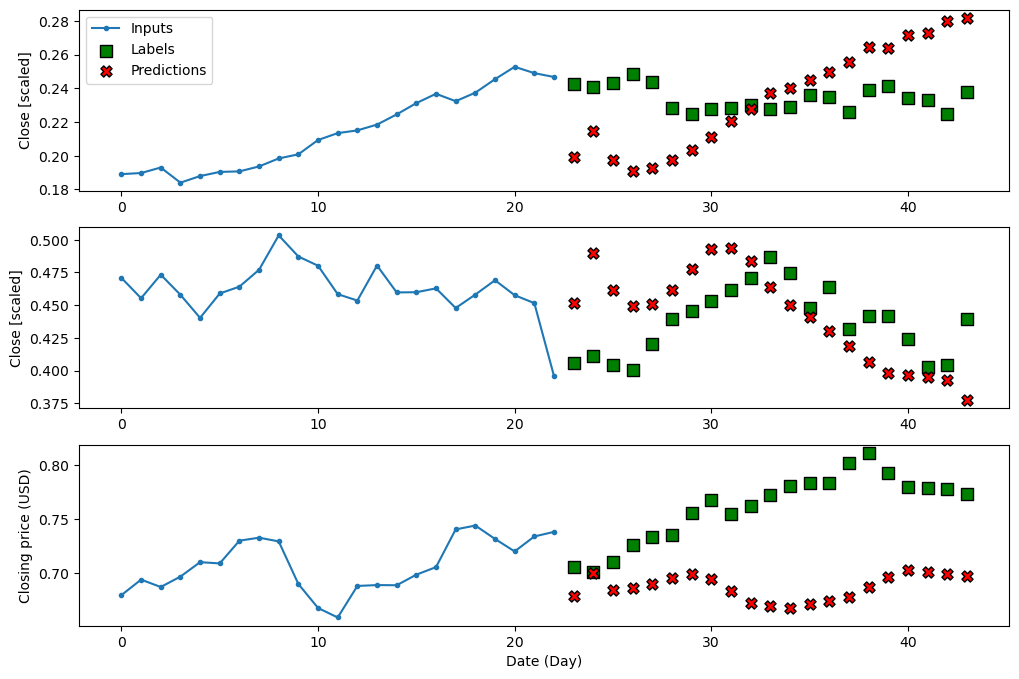

In [71]:
cnn_multi_window.plot(cnn_lstm_model)

# The Autoregressive LSTM model - Using Predictions To Make More Predictions

In [72]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [73]:
AR_LSTM = AutoRegressive(units=32, out_steps=21)

In [74]:
history = compile_and_fit(AR_LSTM, multi_window)

val_performance['ARLSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['ARLSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.1075 - mean_absolute_error: 0.2258 - val_loss: 0.0082 - val_mean_absolute_error: 0.0719
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0439 - val_loss: 0.0055 - val_mean_absolute_error: 0.0572
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029 - mean_absolute_error: 0.0401 - val_loss: 0.0126 - val_mean_absolute_error: 0.0870
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0405 - val_loss: 0.0041 - val_mean_absolute_error: 0.0479
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0368 - val_loss: 0.0039 - val_mean_absolute_error: 0.0457
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - mean_absolute_error: 0.0350 - val_loss: 0.0036 - val_mean_absolute_error: 0.0438
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0366 - val_loss

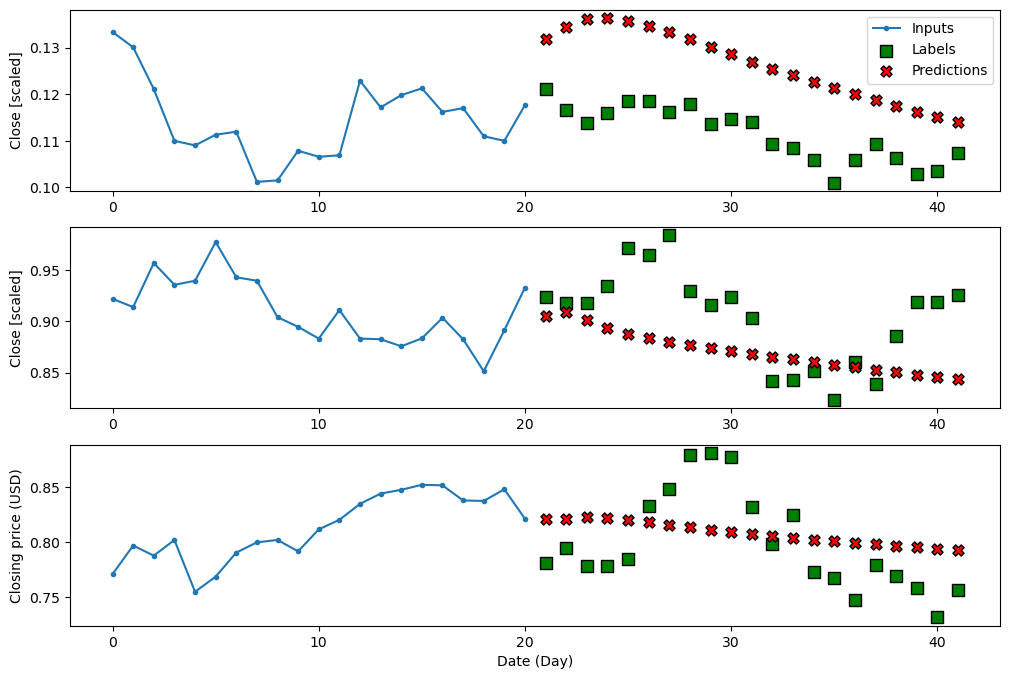

In [75]:
multi_window.plot(AR_LSTM)

# Selecting Best Model

In [76]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

<Figure size 1000x600 with 0 Axes>

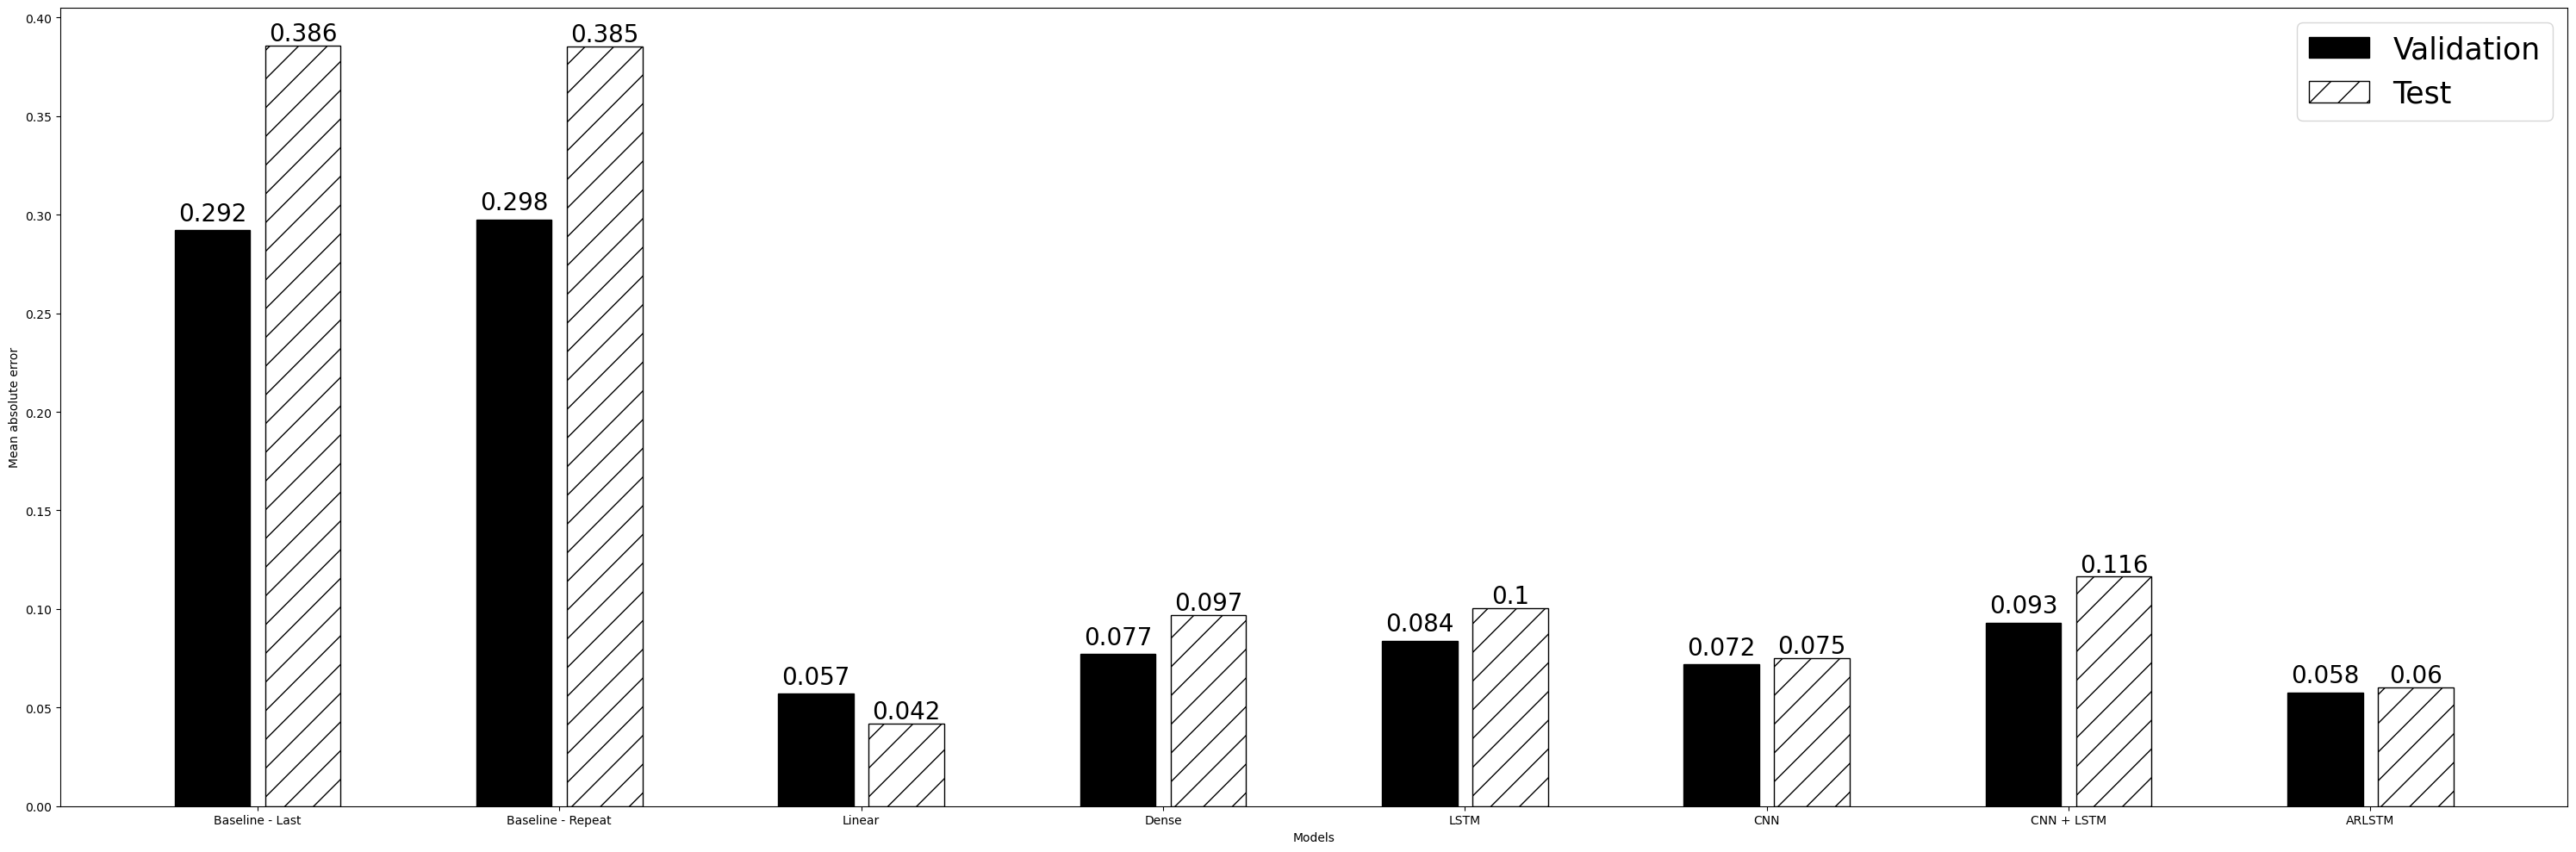

<Figure size 1000x600 with 0 Axes>

In [77]:
x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')


font_prop = font_manager.FontProperties( size=20)

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')

plt.legend(fontsize=25) # using a size in points

plt.tight_layout()
plt.figure(figsize=(10,6))

In [78]:
model_names = ['Baseline-Last', 'Baseline-Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'LSTM+CNN', 'ARLSTM']
data = {'Test - MAE': mae_test, 'Validation - MAE': mae_val}
df = pd.DataFrame(data, index=model_names)
df_sorted = df.sort_values(by='Test - MAE', ascending=True)
df_sorted.T

,Linear,ARLSTM,CNN,Dense,LSTM,LSTM+CNN,Baseline-Repeat,Baseline-Last
Test - MAE,0.041828,0.060187,0.075068,0.097040,0.100459,0.116367,0.385195,0.385661
Validation - MAE,0.057071,0.057679,0.071984,0.077027,0.083817,0.093130,0.297669,0.292086
